In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt; 
from keras.applications.vgg16 import VGG16
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input
# Importing sklearn libraries
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score
import pickle
# Importing Keras libraries
from keras.utils import np_utils
from keras.models import Sequential
from keras.applications import VGG16
from keras.applications import imagenet_utils
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.layers import Dense, Conv2D, MaxPooling2D
from keras.layers import Dropout, Flatten, GlobalAveragePooling2D
 
import warnings
warnings.filterwarnings('ignore')
import cv2
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

Using TensorFlow backend.


In [2]:
%cd /kaggle/working/
!ls

/kaggle/working
__notebook__.ipynb


In [3]:
!wget https://www.dropbox.com/s/sh5yt160xzqjkk0/Food-11.zip?dl=1

--2020-03-16 12:40:32--  https://www.dropbox.com/s/sh5yt160xzqjkk0/Food-11.zip?dl=1
Resolving www.dropbox.com (www.dropbox.com)... 162.125.1.1, 2620:100:601b:1::a27d:801
Connecting to www.dropbox.com (www.dropbox.com)|162.125.1.1|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/dl/sh5yt160xzqjkk0/Food-11.zip [following]
--2020-03-16 12:40:32--  https://www.dropbox.com/s/dl/sh5yt160xzqjkk0/Food-11.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucdd2764a8df950d481bc58edf2b.dl.dropboxusercontent.com/cd/0/get/A0B0hRPWt5weVcQ-2ju2WBZgh6JmplZM8_eHZ4JZqLobDCstcNSHh8qev9g6wKCA_GdFxyIpA8VgR-_7A07SyXuVWUQtalGqRylpe02SuUgG5R9unGw0LcHtm2qDSJ64RuA/file?dl=1# [following]
--2020-03-16 12:40:32--  https://ucdd2764a8df950d481bc58edf2b.dl.dropboxusercontent.com/cd/0/get/A0B0hRPWt5weVcQ-2ju2WBZgh6JmplZM8_eHZ4JZqLobDCstcNSHh8qev9g6wKCA_GdFxyIpA8VgR-_7A07SyXuVWUQtalGqRylpe02SuUgG5R9unGw

In [4]:
!mv Food-11.zip?dl=1 Food_11.zip

In [5]:
!unzip Food_11.zip

Archive:  Food_11.zip
   creating: evaluation/
  inflating: evaluation/0_0.jpg      
  inflating: evaluation/0_1.jpg      
  inflating: evaluation/0_10.jpg     
  inflating: evaluation/0_100.jpg    
  inflating: evaluation/0_101.jpg    
  inflating: evaluation/0_102.jpg    
  inflating: evaluation/0_103.jpg    
  inflating: evaluation/0_104.jpg    
  inflating: evaluation/0_105.jpg    
  inflating: evaluation/0_106.jpg    
  inflating: evaluation/0_107.jpg    
  inflating: evaluation/0_108.jpg    
  inflating: evaluation/0_109.jpg    
  inflating: evaluation/0_11.jpg     
  inflating: evaluation/0_110.jpg    
  inflating: evaluation/0_111.jpg    
  inflating: evaluation/0_112.jpg    
  inflating: evaluation/0_113.jpg    
  inflating: evaluation/0_114.jpg    
  inflating: evaluation/0_115.jpg    
  inflating: evaluation/0_116.jpg    
  inflating: evaluation/0_117.jpg    
  inflating: evaluation/0_118.jpg    
  inflating: evaluation/0_119.jpg    
  inflating: evaluation/0_12.jpg     
  i

In [6]:
!ls

Food_11.zip  __notebook__.ipynb  evaluation  training  validation


In [7]:
!rm -rf Food_11.zip

In [8]:
train = [os.path.join("training",img) for img in os.listdir("training")]
val = [os.path.join("validation",img) for img in os.listdir("validation")]
test = [os.path.join("evaluation",img) for img in os.listdir("evaluation")]
len(train),len(val),len(test)
# len(test)

(9866, 3430, 3347)

In [9]:
train_y = [int(img.split("/")[-1].split("_")[0]) for img in train]
val_y = [int(img.split("/")[-1].split("_")[0]) for img in val]
test_y = [int(img.split("/")[-1].split("_")[0]) for img in test]
num_classes = 11
# Convert class labels in one hot encoded vector
y_train = []
for x in train_y:
    a = np.array([0]*num_classes)
    a[x] = 1
    y_train.append(a)
y_val = []
for x in val_y:
    a = np.array([0]*num_classes)
    a[x] = 1
    y_val.append(a)
y_test = []
for x in test_y:
    a = np.array([0]*num_classes)
    a[x] = 1
    y_test.append(a)
    
#len(y_train),len(y_val),len(y_test)
y_train = np.array(y_train)
y_val = np.array(y_val)
y_test = np.array(y_test)
y_train.shape,y_val.shape,y_test.shape

((9866, 11), (3430, 11), (3347, 11))

In [10]:
import pickle
with open("test_op.pkl","wb") as file:
    pickle.dump(y_test,file)
with open("train_op.pkl","wb") as file:
    pickle.dump(y_train,file)
with open("val_op.pkl","wb") as file:
    pickle.dump(y_val,file)

In [11]:
print("Reading train images..")
X_train = [cv2.resize(cv2.imread(x), dsize=(224,224), interpolation=cv2.INTER_AREA) for x in train]
print("Done.")
len(X_train)

Reading train images..
Done.


9866

In [12]:
model = VGG16(weights="imagenet", include_top=False)
outs = []
for img in X_train:
    x = preprocess_input(np.expand_dims(image.img_to_array(img), axis=0))
    outs.append(model.predict(x)[0])
    if len(outs) % 100 == 0:
        print(len(outs))
outs = np.array(outs)
outs.shape
# print("creating train features..")
# train_x, train_features, train_features_flatten = create_features(train, model)
# print("creating val features..")
# val_x, val_features, val_features_flatten = create_features(val, model)
# test_x, test_features, test_features_flatten = create_features(test, model)

# print(train_x.shape, train_features.shape, train_features_flatten.shape)
# print(val_x.shape, val_features.shape, val_features_flatten.shape)
# print(test_x.shape, test_features.shape, test_features_flatten.shape)

58892288/58889256 [==============================] - 2s 0us/step
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800


(9866, 7, 7, 512)

In [13]:
print(outs.shape)
with open("train_features.pkl","wb") as file:
    pickle.dump(outs,file)

(9866, 7, 7, 512)


In [14]:
print("Reading val images..")
outs = []
X_train = []
X_val = [cv2.resize(cv2.imread(x), dsize=(224,224), interpolation = cv2.INTER_AREA) for x in val]
print("Done.")
len(X_val)

Reading val images..
Done.


3430

In [15]:
model = VGG16(weights="imagenet", include_top=False)
for img in X_val:
    x = preprocess_input(np.expand_dims(image.img_to_array(img), axis=0))
    outs.append(model.predict(x)[0])
    if len(outs) % 100 == 0:
        print(len(outs))
outs = np.array(outs)
outs.shape

100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400


(3430, 7, 7, 512)

In [16]:
print(outs.shape)
with open("val_features.pkl","wb") as file:
    pickle.dump(outs,file)

(3430, 7, 7, 512)


In [17]:
outs = []
X_val = []
print("Reading test images..")
X_test = [cv2.resize(cv2.imread(x), dsize=(224,224), interpolation = cv2.INTER_AREA) for x in test]
print("Done.")
len(X_test)

Reading test images..
Done.


3347

In [18]:
model = VGG16(weights="imagenet", include_top=False)
for img in X_test:
    x = preprocess_input(np.expand_dims(image.img_to_array(img), axis=0))
    outs.append(model.predict(x)[0])
    if len(outs) % 100 == 0:
        print(len(outs))
outs = np.array(outs)
outs.shape

100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300


(3347, 7, 7, 512)

In [19]:
print(outs.shape)
with open("test_features.pkl","wb") as file:
    pickle.dump(outs,file)

(3347, 7, 7, 512)


In [20]:
outs = []
X_train = []
X_val = []
X_test = []

# val_features = []
# train_features = []
val_features = pickle.load(open("val_features.pkl","rb"))
train_features = pickle.load(open("train_features.pkl","rb"))
test_features = pickle.load(open("test_features.pkl","rb"))

In [21]:
y_test = []
with open("test_op.pkl","rb") as file:
    y_test = pickle.load(file)
y_train = []
with open("train_op.pkl","rb") as file:
    y_train = pickle.load(file)
y_val = []
with open("val_op.pkl","rb") as file:
    y_val = pickle.load(file)

In [22]:
print(train_features.shape, y_train.shape)
print(val_features.shape, y_val.shape)
print(test_features.shape,y_test.shape)

(9866, 7, 7, 512) (9866, 11)
(3430, 7, 7, 512) (3430, 11)
(3347, 7, 7, 512) (3347, 11)


In [23]:
checkpointer = ModelCheckpoint(filepath='transfermodel_best.hdf5',
                               verbose=1,save_best_only=True)
model_transfer = Sequential()
model_transfer.add(GlobalAveragePooling2D(input_shape=train_features.shape[1:]))
model_transfer.add(Dropout(0.2))
model_transfer.add(Dense(120, activation='relu'))
model_transfer.add(Dense(256, activation='relu'))
model_transfer.add(Dense(11, activation='softmax'))
model_transfer.compile(loss='categorical_crossentropy', optimizer='adam',
              metrics=['accuracy'])
history = model_transfer.fit(train_features, y_train, batch_size=64, epochs=30,
          validation_data=(val_features, y_val), callbacks=[checkpointer],
          verbose=1, shuffle=True)

Train on 9866 samples, validate on 3430 samples
Epoch 1/30
9866/9866 [==============================] - 1s 150us/step - loss: 1.6718 - accuracy: 0.4870 - val_loss: 1.0429 - val_accuracy: 0.6487

Epoch 00001: val_loss improved from inf to 1.04290, saving model to transfermodel_best.hdf5
Epoch 2/30
9866/9866 [==============================] - 1s 121us/step - loss: 1.0081 - accuracy: 0.6680 - val_loss: 0.8382 - val_accuracy: 0.7277

Epoch 00002: val_loss improved from 1.04290 to 0.83824, saving model to transfermodel_best.hdf5
Epoch 3/30
9866/9866 [==============================] - 1s 125us/step - loss: 0.8561 - accuracy: 0.7138 - val_loss: 0.8198 - val_accuracy: 0.7364

Epoch 00003: val_loss improved from 0.83824 to 0.81977, saving model to transfermodel_best.hdf5
Epoch 4/30
9866/9866 [==============================] - 1s 132us/step - loss: 0.7897 - accuracy: 0.7361 - val_loss: 0.7656 - val_accuracy: 0.7504

Epoch 00004: val_loss improved from 0.81977 to 0.76563, saving model to transfer

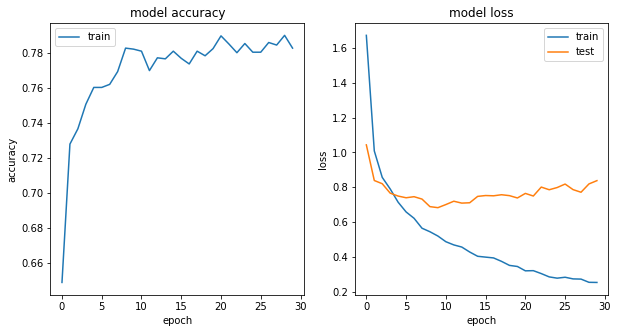

In [24]:
def plot_acc_loss(history):
    fig = plt.figure(figsize=(10,5))
    plt.subplot(1, 2, 1)
#     plt.plot(history.history['acc'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
 
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper right')
    plt.show()
 
plot_acc_loss(history)


In [25]:
model_transfer.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d_1 ( (None, 512)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 120)               61560     
_________________________________________________________________
dense_2 (Dense)              (None, 256)               30976     
_________________________________________________________________
dense_3 (Dense)              (None, 11)                2827      
Total params: 95,363
Trainable params: 95,363
Non-trainable params: 0
_________________________________________________________________


In [26]:
from keras.models import Model
intermediate_layer_model = Model(inputs=model_transfer.input,
                                 outputs=model_transfer.get_layer("dense_2").output)


In [27]:
train_feats = intermediate_layer_model.predict(train_features)
train_features = []
val_feats = intermediate_layer_model.predict(val_features)
# val_features = []
test_feats = intermediate_layer_model.predict(test_features)
# test_features = []

In [28]:
train_feats.shape,val_feats.shape,test_feats.shape

((9866, 256), (3430, 256), (3347, 256))

In [29]:
len(train_y), len(val_y), len(test_y)

(9866, 3430, 3347)

In [30]:
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
# clf = RandomForestClassifier(max_depth=28,n_estimators=150,random_state=0) --> 78.83 val acc
# clf = RandomForestClassifier(max_depth=28,n_estimators=150,random_state=170) # --> 78.65
# clf = RandomForestClassifier(max_depth=28,n_estimators=150,random_state=180) # --> 78.74
# clf = RandomForestClassifier(max_depth=28,n_estimators=150,random_state=190) # --> 78.77
# clf = RandomForestClassifier(max_depth=28,n_estimators=150,random_state=200) # --> 78.86
# clf = RandomForestClassifier(max_depth=28,n_estimators=150,random_state=210) # --> 78.54
# clf = RandomForestClassifier(max_depth=28,n_estimators=150,random_state=220) # --> 78.51
# clf = RandomForestClassifier(max_depth=28,n_estimators=150,random_state=230) # --> 78.89
# clf = RandomForestClassifier(max_depth=28,n_estimators=200,random_state=230) # --> 78.92
# clf = RandomForestClassifier(max_depth=28,n_estimators=220,random_state=230) # --> 78.95
# clf = RandomForestClassifier(max_depth=30,n_estimators=220,random_state=230) # --> 78.97
# clf = RandomForestClassifier(max_depth=45,n_estimators=220,random_state=230) # --> 79.06
clf = RandomForestClassifier(max_depth=45,n_estimators=220,random_state=230)
clf.fit(train_feats,np.array(train_y))

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=45, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=220,
                       n_jobs=None, oob_score=False, random_state=230,
                       verbose=0, warm_start=False)

In [31]:
from sklearn.svm import SVC
svc = SVC(kernel='rbf',gamma='scale',decision_function_shape='ovo',probability=True)
svc.fit(train_feats,np.array(train_y))

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovo', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=False)

In [32]:
SVM_val_outputs = svc.predict(val_feats)
SVM_test_outputs = svc.predict(test_feats)
SVM_val_outputs.shape, SVM_test_outputs.shape
print("SVM accuracies:")
print("val:",accuracy_score(val_y,SVM_val_outputs))
print("test:",accuracy_score(test_y,SVM_test_outputs))

SVM accuracies:
val: 0.7979591836734694
test: 0.8216313116223484


In [33]:
RF_val_outputs = clf.predict(val_feats)
RF_test_outputs = clf.predict(test_feats)
RF_val_outputs.shape, RF_test_outputs.shape
print("RF accuracies:")
print("val:",accuracy_score(val_y,RF_val_outputs))
print("test:",accuracy_score(test_y,RF_test_outputs))

RF accuracies:
val: 0.792128279883382
test: 0.8120705109052884


In [34]:
tm_val = model_transfer.predict(val_features)
tm_test = model_transfer.predict(test_features)
preds = np.argmax(tm_val, axis=1)
print("Transfer model accuracies:")
print("val", accuracy_score(val_y, preds))
preds2 = np.argmax(tm_test, axis=1)
print("test", accuracy_score(test_y, preds2))

Transfer model accuracies:
val 0.7825072886297376
test 0.8117717358828802


In [35]:
SVM_val_outputs = svc.predict_proba(val_feats)
SVM_test_outputs = svc.predict_proba(test_feats)
SVM_val_outputs.shape, SVM_test_outputs.shape

((3430, 11), (3347, 11))

In [36]:
RF_val_outputs = clf.predict_proba(val_feats)
RF_test_outputs = clf.predict_proba(test_feats)
RF_val_outputs.shape, RF_test_outputs.shape

((3430, 11), (3347, 11))

In [37]:
len(val_y)

3430

In [38]:
# SVM accuracies:
# val: 0.7880466472303207
# test: 0.8037048102778608
# RF accuracies:
# val: 0.79067055393586
# test: 0.8099790857484315
# Transfer model accuracies:
# val 0.7740524781341108
# test 0.7842844338213325
# w1 = 2; w2 = 2; w3 = 1.05 --> 79.09 val acc.

In [39]:
w1 = 2; w2 = 2; w3 = 1.05# 79
finprobs = []
for i in range(3430):
    p1 = SVM_val_outputs[i].argsort()[-5:][::-1]
    p2 = RF_val_outputs[i].argsort()[-5:][::-1]
    p3 = tm_val[i].argsort()[-5:][::-1]
    p1_scores = sorted(SVM_val_outputs[i])[-5:][::-1]
    p2_scores = sorted(RF_val_outputs[i])[-5:][::-1]
    p3_scores = sorted(tm_val[i])[-5:][::-1]
    probs = [0]*11
    for k in range(5):
        if p1[k]==p2[k] and p1[k] == p3[k]:
            probs[p1[k]] += (w1*p1_scores[k]) + (w2*p2_scores[k]) + (w3*p3_scores[k])
        elif p1[k]==p2[k]:
            probs[p1[k]] += (w1*p1_scores[k]) + (w2*p2_scores[k])
            probs[p3[k]] += (w3*p3_scores[k])
        elif p2[k]==p3[k]:
            probs[p2[k]] += (w2*p2_scores[k]) + (w3*p3_scores[k])
            probs[p1[k]] += (w1*p1_scores[k])
        elif p1[k]==p3[k]:
            probs[p1[k]] += (w1*p1_scores[k]) + (w3*p3_scores[k])
            probs[p2[k]] += (w2*p2_scores[k])
        else:
            probs[p1[k]] += (w1*p1_scores[k])
            probs[p2[k]] += (w2*p2_scores[k])
            probs[p3[k]] += (w3*p3_scores[k])

    probs = np.array(probs).argsort()[-5:][::-1]
    finprobs.append(probs[0])
# print("ensembled!",len(finprobs),len(val_y))
print("val:",accuracy_score(val_y,finprobs))

val: 0.7970845481049562


In [40]:
print(len(test_features))
preds = np.argmax(model_transfer.predict(test_features), axis=1)
print("\nAccuracy on Test Data: ", accuracy_score(test_y, preds))
print("\nNumber of correctly identified imgaes: ",
      accuracy_score(test_y, preds, normalize=False),"\n")
confusion_matrix(test_y, preds, labels=range(0,11))

3347

Accuracy on Test Data:  0.8117717358828802

Number of correctly identified imgaes:  2717 



array([[275,   4,  21,  28,   7,  26,   1,   2,   3,   1,   0],
       [ 11,  93,  20,   3,   5,   5,   0,   2,   6,   2,   1],
       [ 25,  21, 354,  24,  11,  24,   5,   2,   8,  17,   9],
       [ 36,   6,  12, 255,   6,  10,   0,   1,   3,   3,   3],
       [ 18,   2,  15,  10, 201,  31,   1,   1,   3,   3,   2],
       [  5,   0,  12,   9,   7, 387,   1,   0,   8,   2,   1],
       [  0,   0,   0,   2,   0,   0, 141,   1,   0,   1,   2],
       [  2,   0,   1,   0,   2,   0,   1,  86,   0,   3,   1],
       [  7,   5,  14,   6,   1,   6,   1,   0, 261,   2,   0],
       [  2,   2,  10,   4,   0,   2,   2,   0,   4, 472,   2],
       [  5,   1,   4,   5,   5,   6,   4,   1,   8,   0, 192]])

In [41]:
w1 = 2; w2 = 2; w3 = 1.05# 79
finprobs = []
for i in range(3347):
    p1 = SVM_test_outputs[i].argsort()[-5:][::-1]
    p2 = RF_test_outputs[i].argsort()[-5:][::-1]
    p3 = tm_test[i].argsort()[-5:][::-1]
    p1_scores = sorted(SVM_test_outputs[i])[-5:][::-1]
    p2_scores = sorted(RF_test_outputs[i])[-5:][::-1]
    p3_scores = sorted(tm_test[i])[-5:][::-1]
    probs = [0]*11
    for k in range(5):
        if p1[k]==p2[k] and p1[k] == p3[k]:
            probs[p1[k]] += (w1*p1_scores[k]) + (w2*p2_scores[k]) + (w3*p3_scores[k])
        elif p1[k]==p2[k]:
            probs[p1[k]] += (w1*p1_scores[k]) + (w2*p2_scores[k])
            probs[p3[k]] += (w3*p3_scores[k])
        elif p2[k]==p3[k]:
            probs[p2[k]] += (w2*p2_scores[k]) + (w3*p3_scores[k])
            probs[p1[k]] += (w1*p1_scores[k])
        elif p1[k]==p3[k]:
            probs[p1[k]] += (w1*p1_scores[k]) + (w3*p3_scores[k])
            probs[p2[k]] += (w2*p2_scores[k])
        else:
            probs[p1[k]] += (w1*p1_scores[k])
            probs[p2[k]] += (w2*p2_scores[k])
            probs[p3[k]] += (w3*p3_scores[k])

    probs = np.array(probs).argsort()[-5:][::-1]
    finprobs.append(probs[0])
print("ensembled!",len(finprobs),len(test_y))
print("val:",accuracy_score(test_y,finprobs))

ensembled! 3347 3347
val: 0.8192411114430833


## Accuracies
### SVM val: 0.7880466472303207
### RF val: 0.79067055393586
### Transfer model val: 0.7740524781341108
### Ensemble model val: 0.7909620991253644
w1 = 2; w2 = 2; w3 = 1.05 --> test: 0.8096803107260233